# Kaggle dog breed identification

In [2]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
# for progress bar
from tqdm import tqdm_notebook, tqdm, trange
# to print multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [3]:
data_path = '/home/tzortzis/masters-thesis-2019/input/' 

First let's do some data exploration etc etc

In [4]:
all_labels_df = pd.read_csv(os.path.join(data_path,'labels.csv'))
all_labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Enumerate the breeds so we can call them easier

In [5]:
breeds = all_labels_df.breed.unique()
breed2idx = dict((breed,idx) for idx,breed in enumerate(breeds))
idx2breed = dict((idx,breed) for idx,breed in enumerate(breeds))

In [6]:
all_labels_df['label_idx'] = [breed2idx[b] for b in all_labels_df.breed]
all_labels_df.head()

,id,breed,label_idx
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,4


In [7]:
len(all_labels_df['label_idx'])

10222

In [8]:
len(breeds)

120

We will create a custom dataset in order to use the data loader from pytorch since otherwise we would have to split each class in a subfolder for both training and test sets.

In [9]:
class CustomDataset(Dataset):
    def __init__(self, labels_df, img_path, transform=None):
        self.labels_df = labels_df
        self.img_path = img_path
        self.transform = transform
        
    def __len__(self):
        return self.labels_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.img_path, self.labels_df.id[idx]) + '.jpg'
        img = Image.open(image_name)
        label = self.labels_df.label_idx[idx]
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [10]:
training_dataset = CustomDataset(all_labels_df, os.path.join(data_path, 'train'))

If everthing works correctly this should give a golder retriever

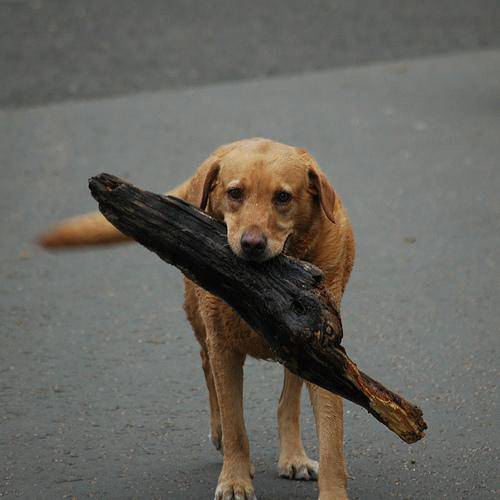

In [11]:
training_dataset[4][0] # :D

Since I am going to use ResNet pretrained from the image net I have to specify the input size that they have been trained with. Otherwise I will destroy the pretrained models

In [12]:
input_size = 224
bs = 64 #If you get a cuda out of memory error restart the kernel and change it into 32 or 16

The data loader feeds images into the model during training and testing. We can specify what kind of transformations want. In general though it's not good to use transformations that do random crops for example since you want to feed images that actual represent the object you are classifying. If you random crop for example the above picture and the crop is on the top left corner then you are asking your network which dog breed is the asphalt which is fine in case of Bayesian deep learning :P

In [13]:
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#these vectors is the mean and the std from the statistics in imagenet. They are always the same as far as I can recall
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Both transformations are taken from pytorch tutorials. Now we need to split the training dataset into a training set and a validation set. I take the training set and I split it into 2 sets. One will be used for training my network and the other will be used like a "test set" during the training to keep track of the overiftting. Which means that I won't use the validation test to tune my weights. It will have no grad there. Only forward to compute a prediction. 

In [14]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
train_split_idx, val_split_idx = next(iter(stratified_split.split(all_labels_df.id, all_labels_df.breed)))
train_df = all_labels_df.iloc[train_split_idx].reset_index()
val_df = all_labels_df.iloc[val_split_idx].reset_index()
#I took this from Kaggle somewhere....

Let's check how the split was made usually 20% of the original training set is enough for the validation

In [15]:
len(train_df), len(val_df)

(8177, 2045)

In [16]:
train_dataset = CustomDataset(train_df, os.path.join(data_path,'train'), transform=data_transforms['train'])
val_dataset = CustomDataset(val_df, os.path.join(data_path,'train'), transform=data_transforms['val'])
image_dataset = {'train':train_dataset, 'val':val_dataset}
dataset_names = ['train', 'val']

image_dataloader = {x:DataLoader(image_dataset[x],batch_size=bs,shuffle=True,num_workers=6) for x in dataset_names}
dataset_sizes = {x:len(image_dataset[x]) for x in dataset_names}

In [17]:
dataset_sizes

{'train': 8177, 'val': 2045}

In [23]:
def train_model(model, loss_fn, optimizer, scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=25):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    # Each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print('Epoch {0}/{1}'.format(epoch+1, num_epochs), end='\t')

        for phase in dataset_names:
            if phase == 'train':
                scheduler.step()
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode


            running_loss = 0.
            running_corrects = 0
            
            # Iterate over data.
            for data in image_dataloader[phase]:
                inps, labels = data
                inps = inps.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inps)
                    _,preds = torch.max(outputs.data,1)
                    loss = loss_fn(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inps.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy model with the best weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc.item()

In [24]:
#load a pretraind resnet50 from imagenet
model_ft = models.resnet50(pretrained=True) 

In [25]:
for param in model_ft.parameters():
    param.requires_grad = False    # By doing this I am keeping the parameters of the feature layers frozen so they won't update

num_fc_ftr = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fc_ftr, 120) #adding a feature extracture for 120 classes

In [26]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {'params':model_ft.fc.parameters()}
], lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [27]:
model_ft, best_acc = train_model(model_ft,criterion,optimizer,scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=10)

Epoch 1/10	train Loss: 3.0317 Acc: 0.3615
val Loss: 1.1427 Acc: 0.7438

Epoch 2/10	train Loss: 1.6958 Acc: 0.5903
val Loss: 0.8427 Acc: 0.7531

Epoch 3/10	train Loss: 1.4480 Acc: 0.6301
val Loss: 0.7229 Acc: 0.7888

Epoch 4/10	train Loss: 1.2296 Acc: 0.6890
val Loss: 0.5810 Acc: 0.8264

Epoch 5/10	train Loss: 1.1947 Acc: 0.6999
val Loss: 0.5770 Acc: 0.8274

Epoch 6/10	train Loss: 1.1877 Acc: 0.7009
val Loss: 0.5720 Acc: 0.8328

Epoch 7/10	train Loss: 1.1875 Acc: 0.7092
val Loss: 0.5642 Acc: 0.8342

Epoch 8/10	train Loss: 1.2059 Acc: 0.7043
val Loss: 0.5647 Acc: 0.8289

Epoch 9/10	train Loss: 1.1742 Acc: 0.7054
val Loss: 0.5661 Acc: 0.8313

Epoch 10/10	train Loss: 1.1623 Acc: 0.7144
val Loss: 0.5731 Acc: 0.8293

Training complete in 5m 0s
Best val Acc: 0.834230


In [35]:
torch.save(model_ft.state_dict(),f"models/resnet50dogs.pt")

In [36]:
from cifar_classifier import MaskedCifar
from classifier import Classifier
from mnist_classifier import MaskedMNist
from pruning.methods import weight_prune, prune_rate
from pruning.utils import to_var
from resnet import MaskedResNet18, MaskedResNet34, MaskedResNet50, MaskedResNet101, MaskedResNet152
import torch.nn.functional as F

In [37]:
pre_prune_accuracy = best_acc
accuracy_thershold = 1./100
prune_perc = 0.
curr_accuracy = pre_prune_accuracy

In [38]:
model = MaskedResNet50(num_classes=120)
model.load_state_dict(torch.load('./models/resnet50dogs.pt'))
model.to(device)

MaskedResNet50(
  (conv1): MaskedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): MaskedSequential(
    (0): MaskedBottleneck(
      (conv1): MaskedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): MaskedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): MaskedSequential(
        (0): MaskedC

In [39]:
while (pre_prune_accuracy - curr_accuracy) < accuracy_thershold:
    prune_perc += 5.
    masks = weight_prune(model, prune_perc)
    model.set_mask(masks)
    print(f"Testing at prune percentage {prune_perc}..")
    model, curr_accuracy = train_model(model_ft,criterion,optimizer,scheduler, dataset_sizes, image_dataloader, dataset_names, num_epochs=4)
    print(f"Accuracy achieved: {curr_accuracy}")
    print(f"Change in accuracy: {pre_prune_accuracy - curr_accuracy}")
    print(f"tracking prepruned accuracy: {pre_prune_accuracy}")

Skipping masking of layer:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Skipping masking of layer:  ReLU(inplace)
Skipping masking of layer:  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Skipping masking of layer:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Skipping masking of layer:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Skipping masking of layer:  BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Skipping masking of layer:  ReLU(inplace)
Skipping masking of layer:  BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Skipping masking of layer:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Skipping masking of layer:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Skipping masking of layer:  BatchNorm2d(256, eps=1e-05,

AttributeError: 'ResNet' object has no attribute 'set_mask'